<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Случайное-дерево" data-toc-modified-id="Случайное-дерево-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Случайное дерево</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Случайное-дерево" data-toc-modified-id="Случайное-дерево-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Случайное дерево</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоговый вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer

from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)

Проверим данные на монотонность

In [3]:
df.index.is_monotonic

True

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Проверим датасет на наличие пропусков.

In [6]:
df.isna().sum()

num_orders    0
dtype: int64

Пропусков в датасете не обнаружено. Все необходимые изменения были применены. Можно переходить к ресемплированию.

In [7]:
df = df.resample('1H').sum()

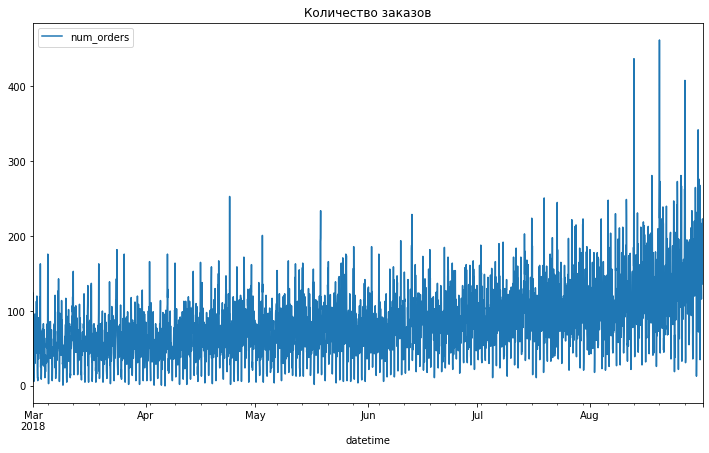

In [8]:
plt.figure(figsize=(12, 7))
plt.title("Количество заказов")
df.plot(ax=plt.gca());

**Промежуточный вывод:**

- Были импортированы необходимые библиотеки
- Индексы датасета были отсортированы
- Данные были проверены на монотонность
- Данные были ресемплированы по 1 часу

## Анализ

Определим скользящее среднее с разбивкой на недельные заказы

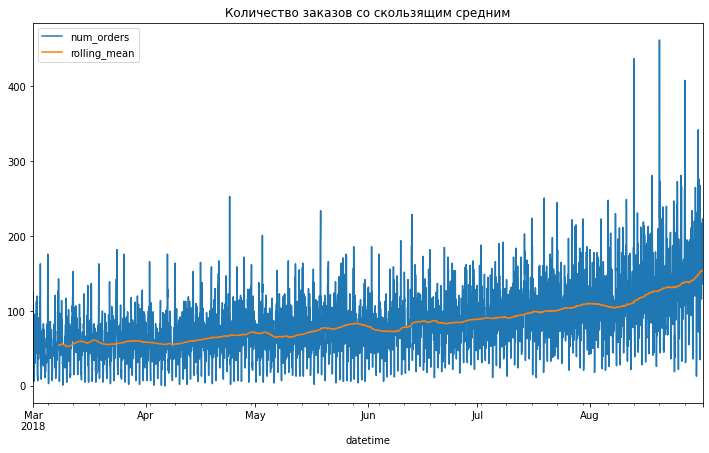

In [9]:
df['rolling_mean'] = df.shift().rolling(24 * 7).mean()
plt.figure(figsize=(12, 7))
plt.title('Количество заказов со скользящим средним')
df.plot(ax=plt.gca());

Декомпозируем данные для определения наличия тренда, сезонности и остатков

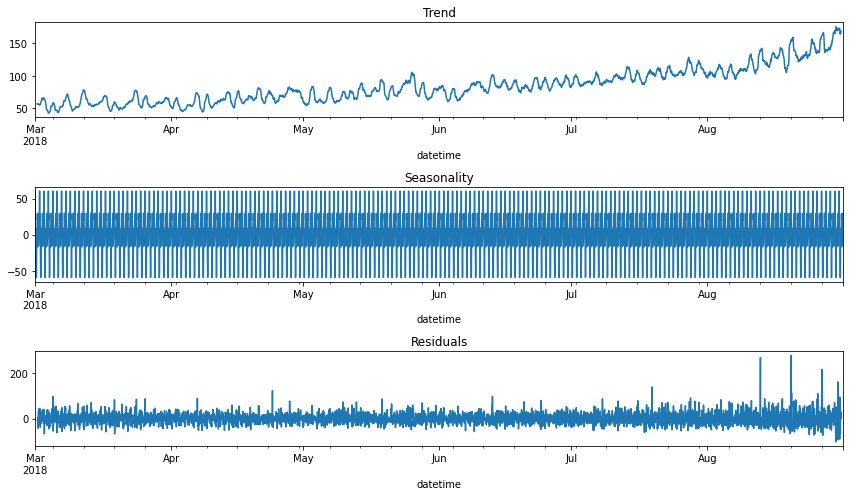

In [10]:
decomposed = seasonal_decompose(df.drop('rolling_mean', axis=1))

plt.figure(figsize=(12, 7))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Из графиков выше виден тренд на постепенное увелечение заказов в течение года. Рассмотрим сезонность с периодом в одну неделю на отдельном графике более подробно.

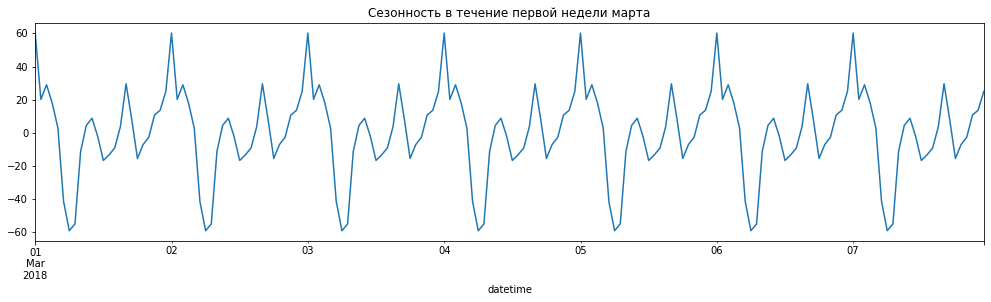

In [11]:
plt.figure(figsize=(17,4))

decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.title('Сезонность в течение первой недели марта');

Из графика видно, что имеет место быть сезонность каждого дня. Рассмотрим отдельно 2 первых дня марта.

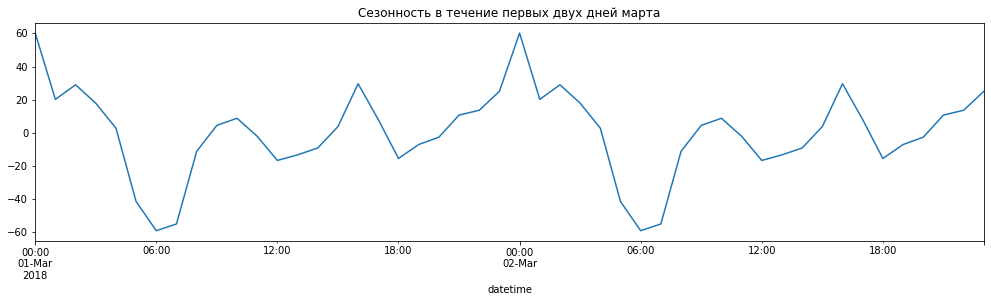

In [12]:
plt.figure(figsize=(17,4))

decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca())
plt.title('Сезонность в течение первых двух дней марта');

Из графика видно, что пик заказов наступает в полночь и спадает к 6 утра каждый день

**Промежуточный вывод:**
- Проанализировали данные со скользящим средним
- Было определено, что в течение года наблюдается тренд на увеличение заказов
- Было определено, что пик заказов наступает в полночь и спадает к 6 часам утра

## Обучение

Создадим отдельную функцию для создания признаков

In [13]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [14]:
df = make_features(df, 24, 7)

Разделим даные на обучающую и тестовую выборки

In [15]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3950 entries, 2018-03-02 00:00:00 to 2018-08-13 13:00:00
Freq: H
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    3950 non-null   int64  
 1   rolling_mean  3950 non-null   float64
 2   year          3950 non-null   int64  
 3   month         3950 non-null   int64  
 4   day           3950 non-null   int64  
 5   dayofweek     3950 non-null   int64  
 6   lag_1         3950 non-null   float64
 7   lag_2         3950 non-null   float64
 8   lag_3         3950 non-null   float64
 9   lag_4         3950 non-null   float64
 10  lag_5         3950 non-null   float64
 11  lag_6         3950 non-null   float64
 12  lag_7         3950 non-null   float64
 13  lag_8         3950 non-null   float64
 14  lag_9         3950 non-null   float64
 15  lag_10        3950 non-null   float64
 16  lag_11        3950 non-null   float64
 17  lag_12        3950 non-null

Проверим соотношение выборок

In [16]:
train_sample = train.shape[0] / df.shape[0]
test_sample = test.shape[0] / df.shape[0]

print('Размер тренировочной выборки- {:.0%}'.format(train_sample))
print('Размер тестовой выборки - {:.0%}'.format(test_sample))

Размер тренировочной выборки- 89%
Размер тестовой выборки - 10%


Данные разделены верно.

In [17]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Напишем отдельную функцию для подсчёта метрики `rmse`.

In [18]:
def rmse(target, predictions):
    return mean_squared_error(target, predictions) ** 0.5

Напишем отдельную функцию для поиска наилучшей модели

In [19]:
def model_proceed(model, params):
    scorer = make_scorer(rmse, greater_is_better=False)
    tss = TimeSeriesSplit(n_splits=5)
    model_grid = GridSearchCV(model, params, cv=tss, scoring=scorer)
    model_grid.fit(features_train, target_train)
    return model_grid

### Линейная регрессия

In [20]:
params = {}
model = LinearRegression()
best_lr = model_proceed(model, params)

### Дерево решений

In [21]:
params = {'max_depth': range(1, 11, 2)}
model = DecisionTreeRegressor()
best_dt = model_proceed(model, params)

### Случайное дерево

In [22]:
params = {'n_estimators': range(5, 26, 2), 'max_depth': range(1, 11, 2)}
model = RandomForestRegressor()
best_rf = model_proceed(model, params)

### LightGBM

In [23]:
params = {
    'n_estimators': range(10, 21, 5),
    'learning_rate': np.arange(0.1, 1.0, 0.5)
}
model = LGBMRegressor()
best_lgbm = model_proceed(model, params)

Построим датафрейм для оценки `rmse` всех моделей на тестовых данных

In [24]:
data = {
    'model': ['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'LightGBM'],
    'rmse_on_train_data': [best_lr.best_score_, best_dt.best_score_, best_rf.best_score_, best_lgbm.best_score_]
}
model_df = pd.DataFrame(data)
model_df

,model,rmse_on_train_data
0,LinearRegression,-27.020278
1,DecisionTreeRegressor,-30.370822
2,RandomForestRegressor,-26.308608
3,LightGBM,-26.821693


## Тестирование

Напишем функцию для отображения всех метрик в графическом виде и сравним их с реальными результатами

In [25]:
def get_graphics_result(model):
    predictions = model.predict(features_test)
    rmse_model = rmse(target_test, predictions)
    
    plt.figure(figsize=(12, 7))
    plt.title('Сравнение предсказанных значений с реальными')
    plt.plot(target_test.index, predictions, 'r', label='Предсказания')
    plt.plot(target_test.index, target_test.values, 'b', label='Реальные значения')
    plt.legend(loc='upper left')
    plt.grid(True)
    
    plt.show()
    
    return rmse_model

### Линейная регрессия

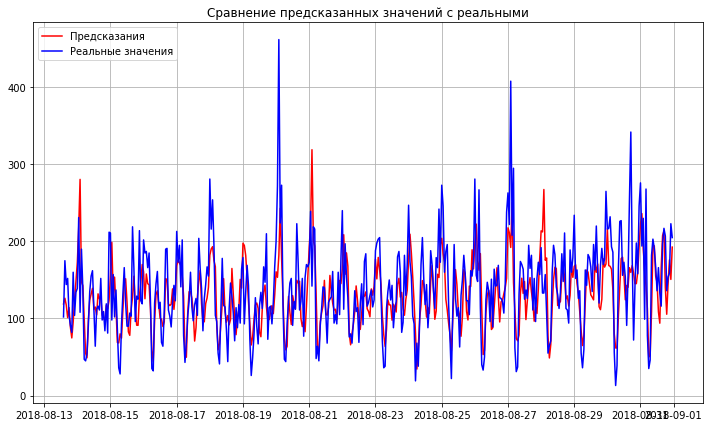

In [26]:
model_df.loc[0, 'rmse_on_test_data'] = get_graphics_result(best_lr.best_estimator_)

### Дерево решений

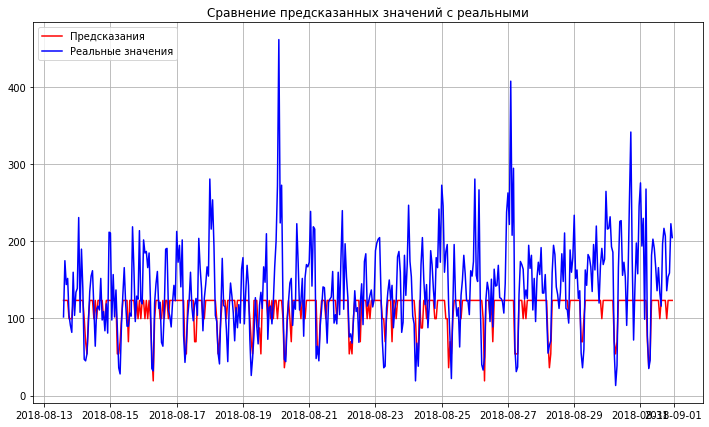

In [27]:
model_df.loc[1, 'rmse_on_test_data'] = get_graphics_result(best_dt.best_estimator_)

### Случайное дерево

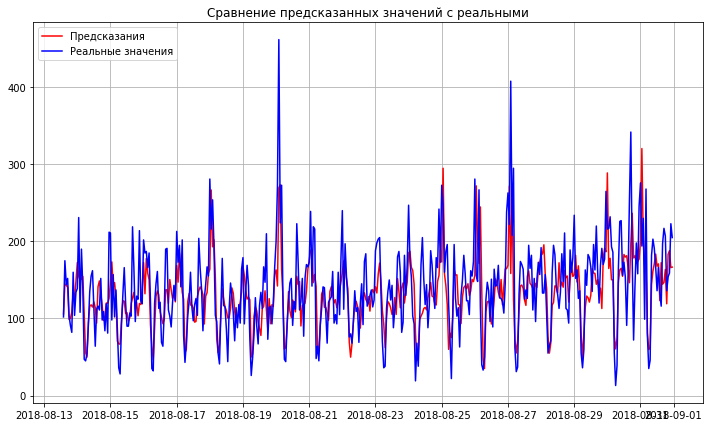

In [28]:
model_df.loc[2, 'rmse_on_test_data'] = get_graphics_result(best_rf.best_estimator_)

### LightGBM

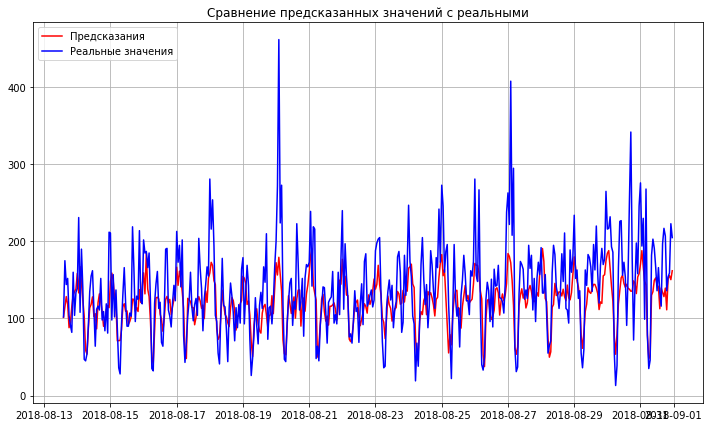

In [29]:
model_df.loc[3, 'rmse_on_test_data'] = get_graphics_result(best_lgbm.best_estimator_)

Выведем итоговый датасет

In [30]:
model_df

,model,rmse_on_train_data,rmse_on_test_data
0,LinearRegression,-27.020278,45.529337
1,DecisionTreeRegressor,-30.370822,57.587201
2,RandomForestRegressor,-26.308608,44.638617
3,LightGBM,-26.821693,46.780494


У трех моделей из четырех значение `rmse` меньше 48, что говорит о том, что мы справились с задачей

## Итоговый вывод

**Предобработка данных**

- Были импортированы необходимые библиотеки
- Индексы датасета были отсортированы
- Данные были проверены на монотонность
- Данные были ресемплированы по 1 часу

**Анализ данных**
- Проанализировали данные со скользящим средним
- Было определено, что в течение года наблюдается тренд на увеличение заказов
- Было определено, что пик заказов наступает в полночь и спадает к 6 часам утра

**Тестирование**

В итоге тестирования моделей, я пришел к выводу, что модели `LinearRegression`, `RandomForestRegressor` и `LightGBM` наилучшим образом подходят для данной задачи, так как их значение `rmse` оказалось лучшим из возможных.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48